<a href="https://colab.research.google.com/github/felixzhao/AIML425-ASSN-3/blob/main/Q5_1-2_TranTestData_AIML425_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=e393f9505bc481cfa049c96c2f4399120a7a98c3b3fd7eafea6b437c96eb7423
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [ ]:
# !pip install --upgrade networkx

In [12]:
import torch
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from scipy.sparse import csr_matrix
import numpy as np
import pickle

In [7]:
def sensor_score(tiger_passed_by, c):
    s = random.uniform(0, 1)  # Random float between 0 and 1

    if tiger_passed_by:
        return s
    else:
        if s < c:
            return 2 * s / c
        else:
            return 2 * (1 - s) / (1 - c)


In [8]:
# # Failure rate
# F = 0.1  # For example, 10% failure rate

# # Constant c
# c = 1e-9

In [38]:
def generate_data(F=0.1, c=1e-9):
    # Grid dimensions
    n = 32  # 32x32 grid
    N = n * n  # Total number of sensors

    # Generate grid with failures and sensor scores
    grid = torch.zeros(n, n)
    for i in range(n):
        for j in range(n):
            if random.random() < F:
                grid[i, j] = 0  # Sensor failed
            else:
                grid[i, j] = sensor_score(False, c)  # Initialize with sensor_score

    # Initialize the tiger's track
    edge = random.choice(["top", "bottom", "left", "right"])
    if edge == "top":
        x, y = 0, random.randint(0, n-1)
    elif edge == "bottom":
        x, y = n-1, random.randint(0, n-1)
    elif edge == "left":
        x, y = random.randint(0, n-1), 0
    else:  # edge == "right"
        x, y = random.randint(0, n-1), n-1

    # Track of the tiger
    track = [(x, y)]

    # Simulate the tiger's movement
    while True:
        dx, dy = random.choice([(-1, -1), (-1, 0), (-1, 1),
                                (0, -1),           (0, 1),
                                (1, -1),  (1, 0),  (1, 1)])
        x, y = x + dx, y + dy

        # Check for exit conditions
        exit_edge = None
        if x < 0:
            exit_edge = "top"
        elif x >= n:
            exit_edge = "bottom"
        elif y < 0:
            exit_edge = "left"
        elif y >= n:
            exit_edge = "right"

        if exit_edge and exit_edge != edge:
            break  # Tiger has left the grid from a different edge

        # If within grid, update the track and grid
        if 0 <= x < n and 0 <= y < n:
            track.append((x, y))

        # # Check for exit conditions
        # if x < 0 or x >= n or y < 0 or y >= n:
        #     break  # Tiger has left the grid

        # # If within grid, update the track
        # track.append((x, y))

    y_label = torch.zeros(n, n).long()

    # Update grid values for the track
    for x, y in track:
        grid[x, y] = sensor_score(True, c)  # Update with sensor_score
        y_label[x, y] = 1

    # Create adjacency matrix
    adj_matrix = torch.zeros(N, N)
    for i in range(n):
        for j in range(n):
            if grid[i, j] == 0:  # Skip failed sensors
                continue
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue  # Skip self-loop
                    x, y = i + dx, j + dy
                    if 0 <= x < n and 0 <= y < n and grid[x, y] != 0:
                        index1 = i * n + j
                        index2 = x * n + y
                        adj_matrix[index1, index2] = 1

    print(len(track))

    # Convert to PyTorch Geometric Data
    edge_index = adj_matrix.nonzero().t().contiguous()
    x = grid.view(-1, 1)  # Node features (sensor scores)
    y_label = y_label.view(-1)  # Flatten the label tensor
    print(y_label)
    data = Data(x=x, edge_index=edge_index, y=y_label)
    return data

In [39]:
# Generate multiple instances
num_instances = 10
all_data = [generate_data() for _ in range(num_instances)]

117
tensor([0, 0, 0,  ..., 0, 1, 1])
190
tensor([0, 0, 0,  ..., 0, 0, 0])
126
tensor([0, 0, 0,  ..., 0, 0, 0])
104
tensor([0, 0, 0,  ..., 0, 0, 0])
1
tensor([1, 0, 0,  ..., 0, 0, 0])
30
tensor([0, 0, 0,  ..., 0, 0, 0])
30
tensor([0, 0, 0,  ..., 0, 0, 0])
33
tensor([0, 0, 0,  ..., 0, 0, 0])
68
tensor([0, 0, 0,  ..., 0, 0, 0])
181
tensor([0, 0, 0,  ..., 0, 0, 0])


In [13]:
# # Save to disk
# with open("all_data.pkl", "wb") as f:
#     pickle.dump(all_data, f)

In [ ]:
# # Load from disk
# with open("all_data.pkl", "rb") as f:
#     loaded_data = pickle.load(f)


In [40]:
# Split into train and test sets
train_size = int(0.8 * len(all_data))
train_data = all_data[:train_size]
test_data = all_data[train_size:]

# Plot

In [41]:
n = 32

<ipython-input-42-8a63c0757012>:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, orientation='vertical', label='Sensor Score')


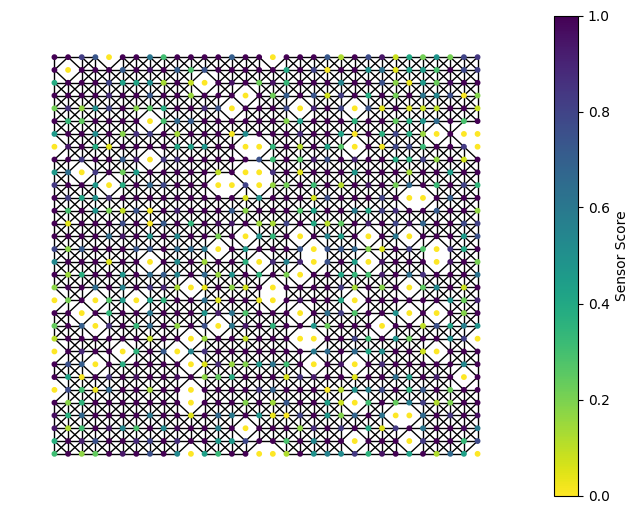

In [42]:
# Extract the first data object from train_data
first_data = train_data[0]

# Extract adjacency matrix and node features
edge_index = first_data.edge_index.numpy()
x = first_data.x.view(-1).numpy()

# Create adjacency matrix from edge_index
N = len(x)
adj_matrix = torch.zeros(N, N)
for i, j in edge_index.T:
    adj_matrix[i, j] = 1

# Convert to SciPy sparse matrix
adj_matrix_numpy = adj_matrix.numpy()
adj_matrix_sparse = csr_matrix(adj_matrix_numpy)

# To visualize the graph, we convert it to a networkx graph and plot
G = nx.from_scipy_sparse_array(adj_matrix_sparse)
pos = {i: [(i // n) % n, i % n] for i in range(N)}
node_colors = [x[i] for i in range(N)]

# Use a colormap to map the sensor score to a color
nx.draw(G, pos, node_size=10, node_color=node_colors, cmap=plt.cm.viridis_r, vmin=0, vmax=1)

# Add a colorbar to show the mapping from sensor score to color
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis_r, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, orientation='vertical', label='Sensor Score')

plt.show()


In [43]:
type(first_data)

torch_geometric.data.data.Data

In [44]:
first_data.x

tensor([[0.3123],
        [0.3670],
        [0.9382],
        ...,
        [1.8367],
        [0.8149],
        [0.8384]])

In [45]:
first_data.edge_index

tensor([[   0,    0,    0,  ..., 1023, 1023, 1023],
        [   1,   32,   33,  ...,  990,  991, 1022]])

In [46]:
first_data.y

tensor([0, 0, 0,  ..., 0, 1, 1])